In [1]:
from kmod import gan_ume_opt as gt
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kmod
import kgof
import kgof.goftest as gof
# submodules
from kmod import data, density, kernel, util
from kmod import mctest as mct
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats

import utils, torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
class generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, dataset='celebA'):
        
        super(generator, self).__init__()
        
        z_size=100
        out_size=3
        ngf=128
        
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output
    def load(self,save_dir):
        self.load_state_dict(torch.load(save_dir))

In [3]:
!CUDA_VISIBLE_DEVICES=1,2
torch.backends.cudnn.enabled = True

In [4]:
data_dir = '../problems/celeba/img_align_celeba'
test_img_list = []
with open('../problems/celeba/test_list.txt') as f:
    for line in f:
        test_img_list.append(line.rstrip('\n'))
filenames = ['{}/{}'.format(data_dir, name) for name in test_img_list]

from PIL import Image
import numpy
img_data = []
for filename in filenames:
    im = numpy.array(Image.open(filename))
    img_data.append(im)

In [5]:
img_data = np.array(img_data) / 255.
img_data.shape

(30000, 64, 64, 3)

In [6]:
batch_size = 200 #number of images we want to generate
z_dim = 100 #dimention of noise, this is fixed to 100 so don't change
model_dir = '../problems/celeba/models/'
gpu_id = 2
gpu_mode = True
gt.set_gpu_mode(gpu_mode)
gt.set_gpu_id(gpu_id)
gp = generator().cuda(gpu_id)
gp.eval()
gq = generator().cuda(gpu_id)
gq.eval()
gp.load('{}/GAN_G_smile_unif.pkl'.format(model_dir))
gq.load('{}/GAN_G_nosmile_unif.pkl'.format(model_dir))

sample_z_ = Variable((torch.rand((batch_size, z_dim))).view(-1, z_dim, 1, 1))
sample_z_ = sample_z_.cuda(gpu_id)
sample_z_ = -2. * sample_z_ + 1.
sample_z_ = sample_z_.float()
samples_p_show = gp(sample_z_).cpu().data.numpy().transpose(0, 2, 3, 1)
samples_p = samples_p_show.reshape([samples_p_show.shape[0], -1])

sample_z_ = Variable((torch.rand((batch_size, z_dim))).view(-1, z_dim, 1, 1))
sample_z_ = sample_z_.cuda(gpu_id)
sample_z_ = -2. * sample_z_ + 1.
sample_z_ = sample_z_.float()
samples_q_show = gq(sample_z_).cpu().data.numpy().transpose(0, 2, 3, 1)
samples_q = samples_q_show.reshape([samples_q_show.shape[0], -1])

tr_data = img_data[:15000].reshape((15000, -1))
datap = data.Data(np.clip(samples_p, 0, 1))
dataq = data.Data(np.clip(samples_q, 0, 1))
datar = data.Data(tr_data[:batch_size])

(-0.5, 63.5, 63.5, -0.5)

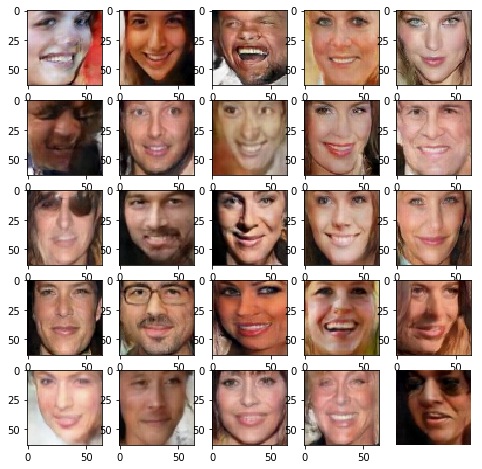

In [7]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

grid_size = 5

for i in range(grid_size**2):

    img = np.clip(samples_p_show[i], 0, 1) 
    
    plt.subplot(grid_size, grid_size, i+1)    

    plt.imshow(img)

plt.axis('off')

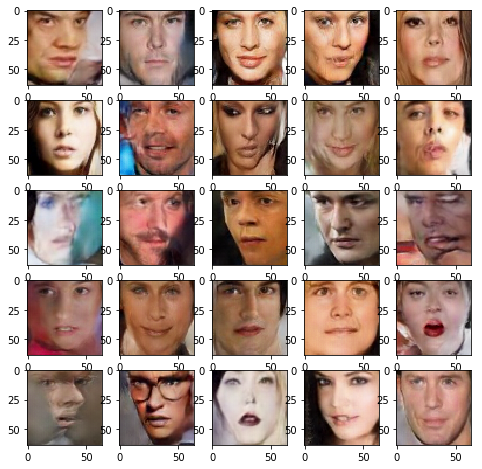

In [8]:
plt.figure(figsize=(8, 8))
for i in range(grid_size**2):

    img = np.clip(samples_q_show[i], 0, 1) 
    
    plt.subplot(grid_size, grid_size, i+1)    

    plt.imshow(img)

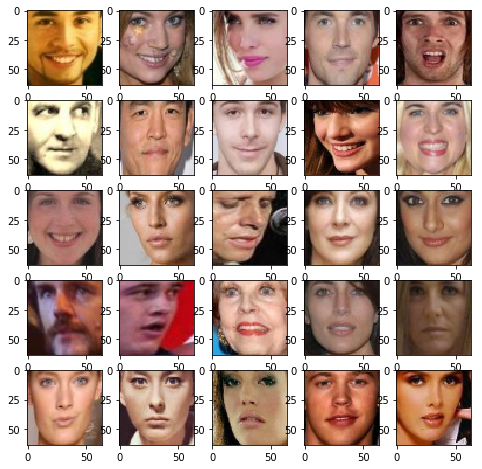

In [9]:
plt.figure(figsize=(8, 8))

for i in range(grid_size**2):
    img = np.clip(img_data[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)
    plt.imshow(img)

In [ ]:
J = 1
Zp0 = Zq0 = np.random.uniform(-1, 1, (J, z_dim))
XYZ = np.vstack((datap.data(), dataq.data(), datar.data()))
med2 = util.meddistance(XYZ, subsample=1000)**2

In [ ]:
Z_opt, gw_opt, opt_result = gt.optimize_3sample_criterion(datap, dataq, datar, gp, gq, Zp0, Zq0, gwidth0=med2)

/nfs/nhome/live/heishirok/anaconda3/lib/python3.6/site-packages/torch/autograd/__init__.py:93: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "


In [ ]:
zp_opt = Variable(torch.from_numpy(Z_opt[:J]).float().view(-1, z_dim, 1, 1)).cuda(gpu_id)
zq_opt = Variable(torch.from_numpy(Z_opt[J:]).float().view(-1, z_dim, 1, 1)).cuda(gpu_id)
sample_p_opt = gp(zp_opt).cpu().data.numpy().transpose(0, 2, 3, 1)
sample_q_opt = gq(zp_opt).cpu().data.numpy().transpose(0, 2, 3, 1)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(sample_p_opt.shape[0]):
    img = np.clip(sample_p_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(sample_q_opt.shape[0]):
    img = np.clip(sample_q_opt[i], 0, 1) 
    plt.subplot(grid_size, grid_size, i+1)    
    plt.imshow(img)